![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/visual-nlp-workshop/blob/master/webinars/dicom_deid/1.SparkOcrDicomMetadata.ipynb)

# Example of usage Spark OCR for extract metadata from Dicom document

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar`
- or `secret` for Spark OCR
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-61cecc3adb56)

In [1]:
# NBVAL_SKIP
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade
# needed for Colab
%pip install numpy==1.23.1

## Restart COLAB at this point

In [ ]:
# NBVAL_SKIP
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

## Initialization of spark session

In [2]:
from sparkocr import start
import os
import sys

spark = start(secret=SPARK_OCR_SECRET)

spark

Spark version: 3.2.1
Spark NLP version: 5.4.1
Spark NLP for Healthcare version: 5.4.1
Spark OCR version: 5.4.2rc2



## Import Spark OCR transformers

In [3]:
import pandas as pd

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
import pyspark.sql.functions as f

from pyspark.ml import PipelineModel, Pipeline

## Define OCR transformers and pipeline

In [4]:
dicom = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata")

## Read dicom objects as binary file and display metadata


In [5]:
import pkg_resources
dicom_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/dicoms')
dicom_df = spark.read.format("binaryFile").option("recursiveFileLookup", "false").load(dicom_path)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Compute Stats about dataset

In [7]:
# size in MB
dicom_df.select(f.col("length") / 2**20).summary().show()

+-------+-------------------+
|summary| (length / 1048576)|
+-------+-------------------+
|  count|                  3|
|   mean| 0.6730836232503256|
| stddev|  0.302010905243357|
|    min|0.40700531005859375|
|    25%|0.40700531005859375|
|    50%| 0.6108989715576172|
|    75%| 1.0013465881347656|
|    max| 1.0013465881347656|
+-------+-------------------+



## Show dicom

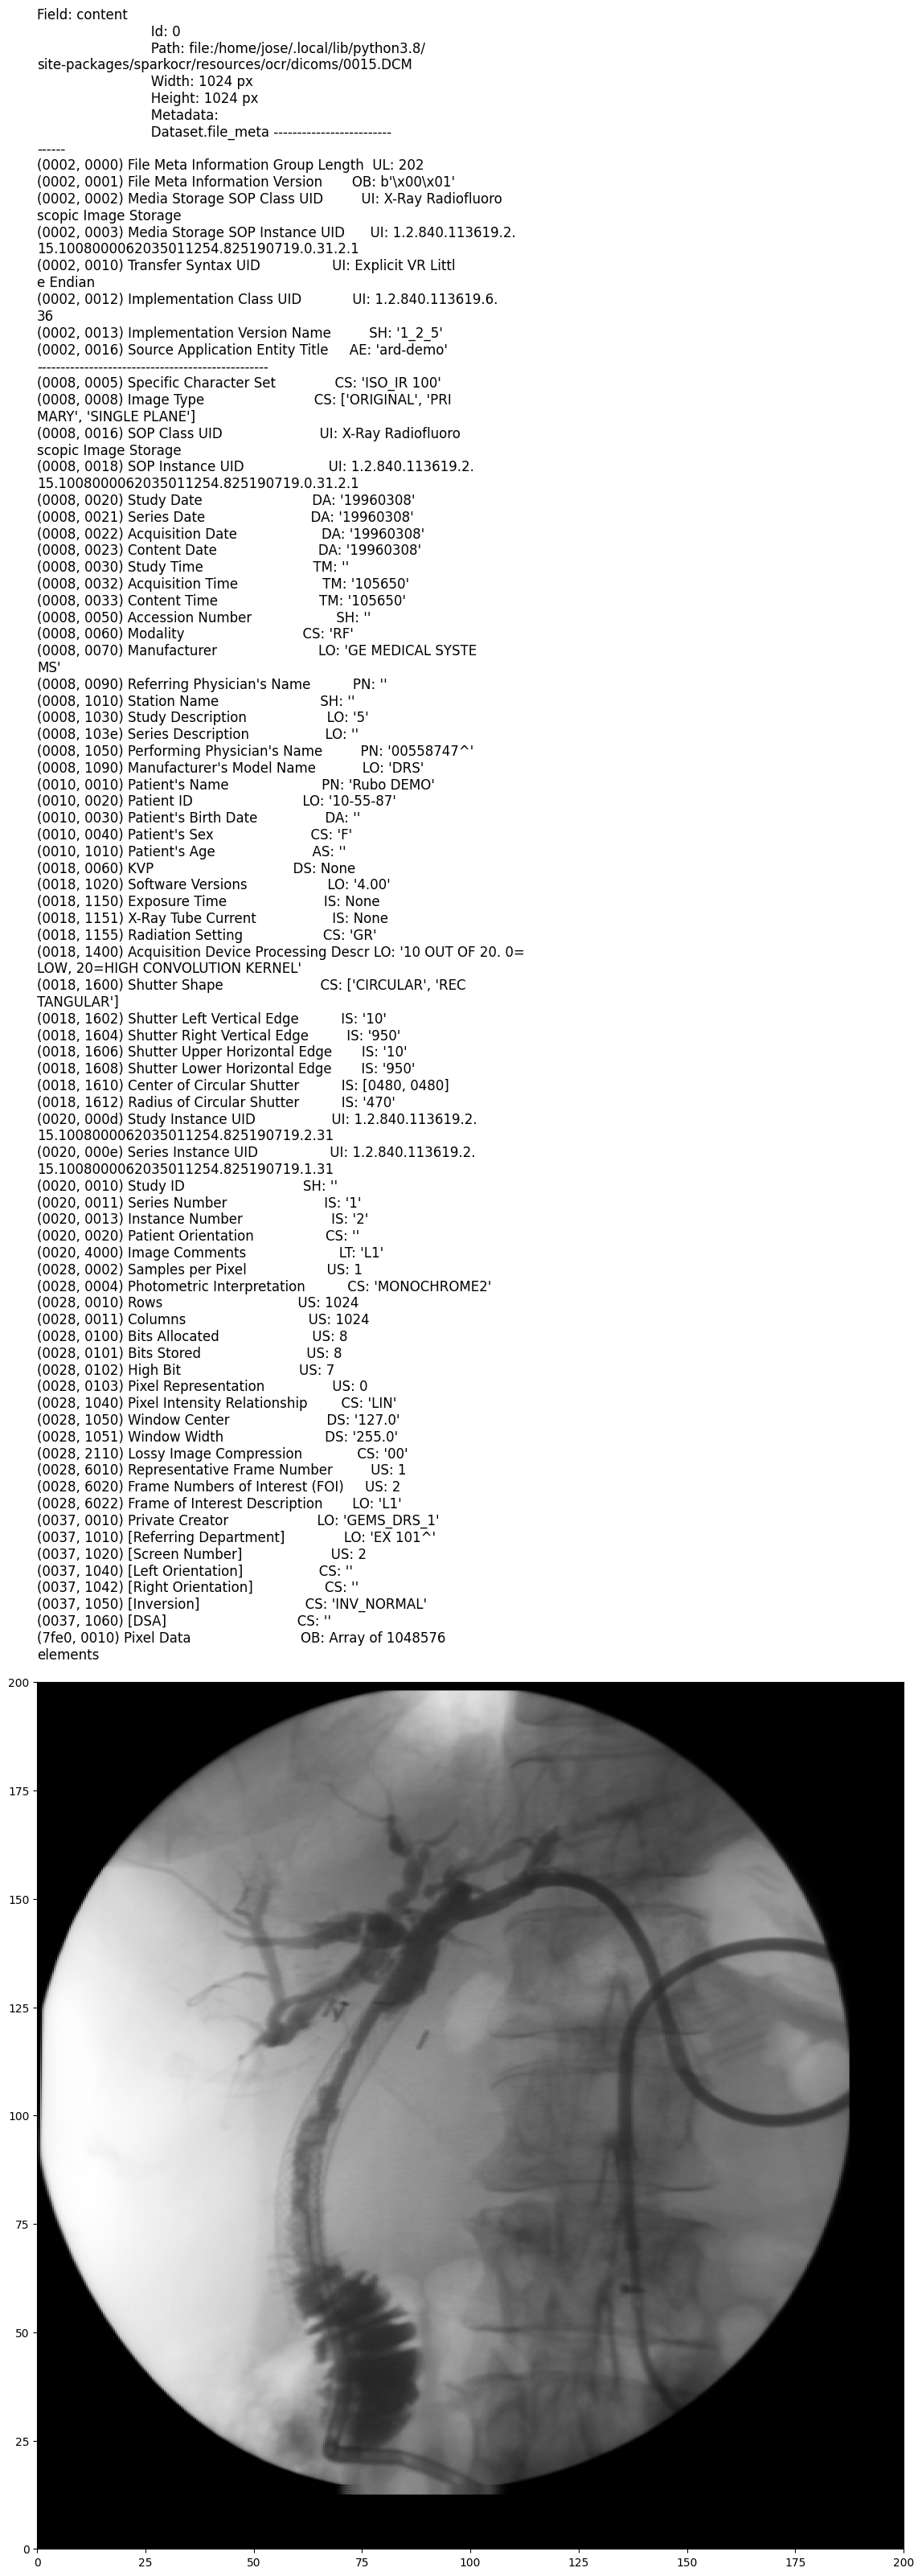

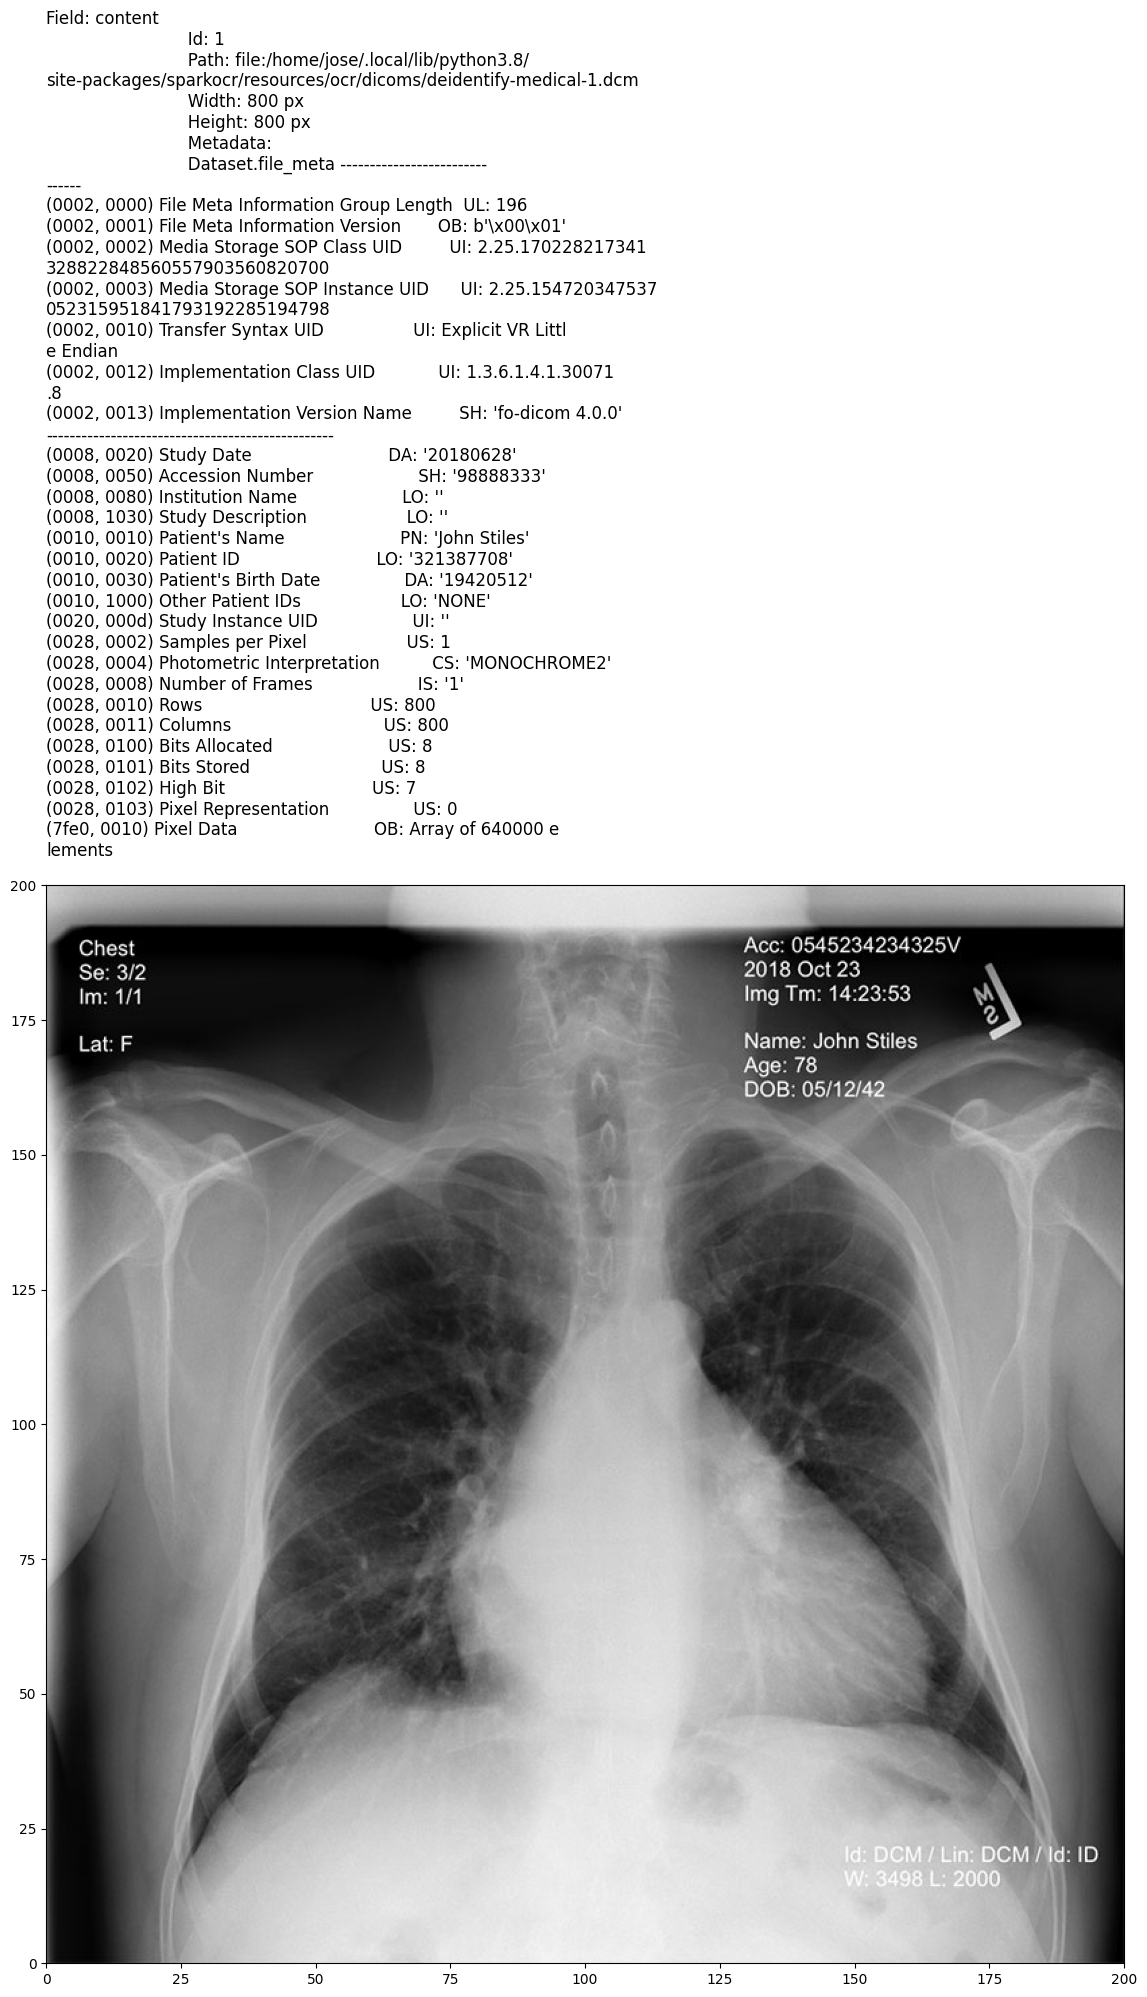

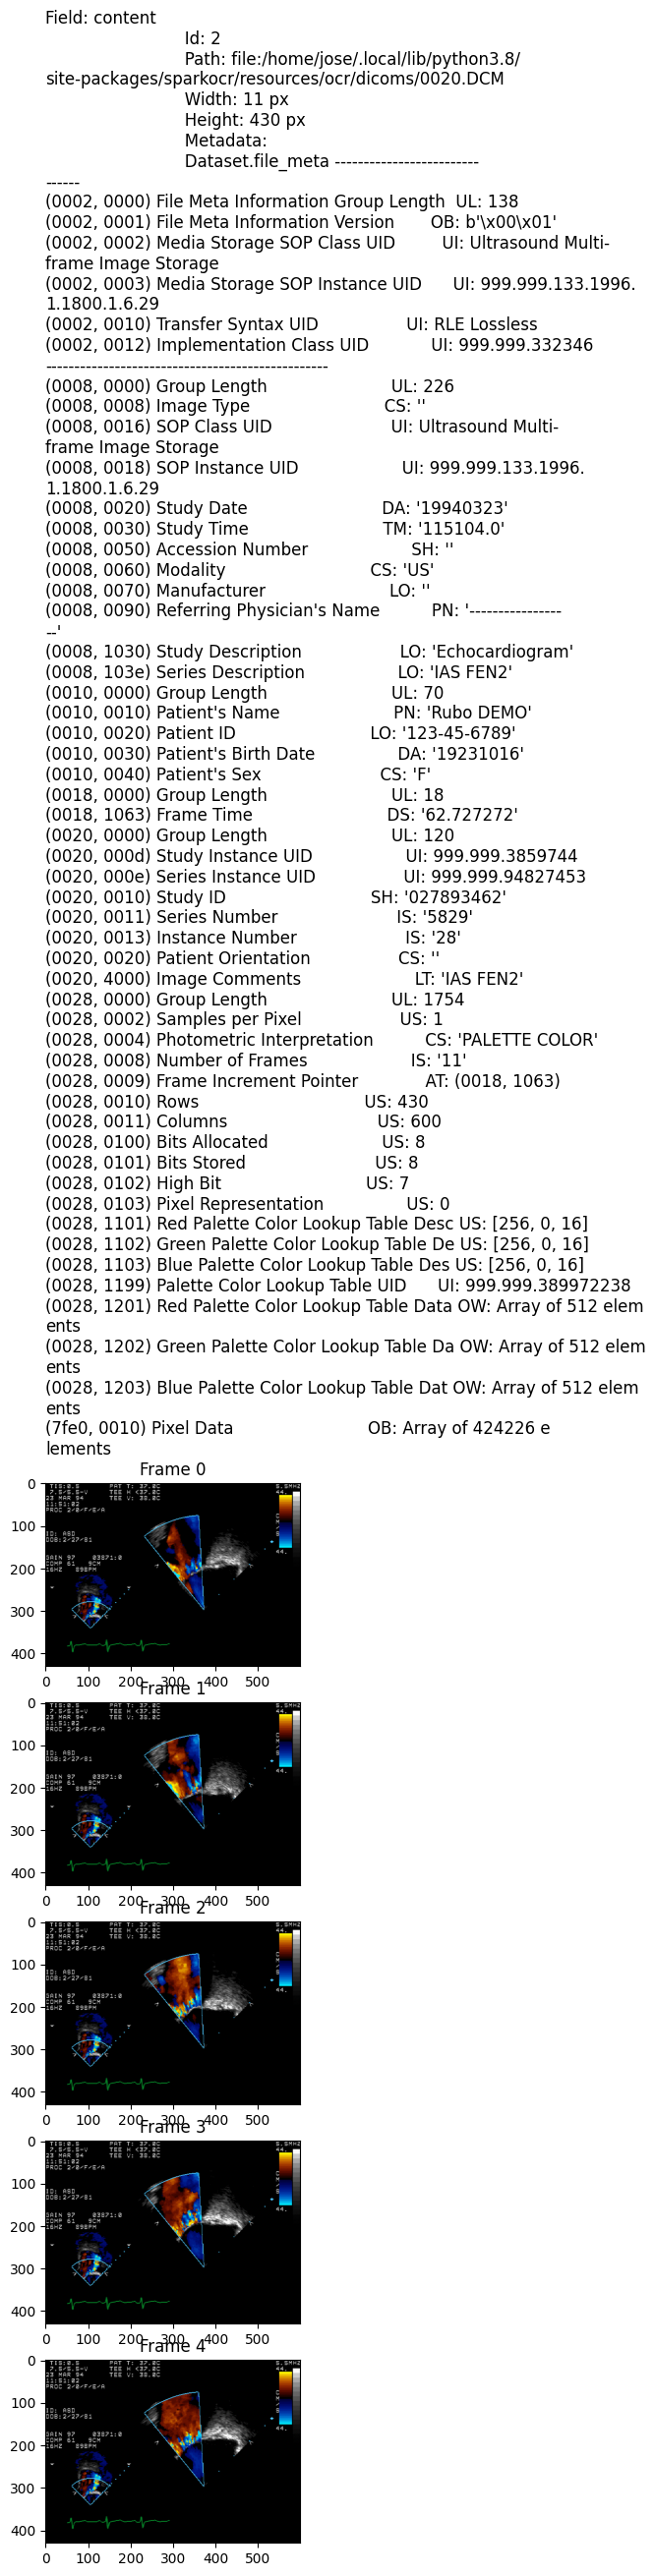

In [24]:
display_dicom(dicom_df, "content")

## Read matadata of dicom document to the dataframe
'metadata' column will contains it as a string

In [8]:
result = dicom.transform(dicom_df)
result

path,modificationTime,length,metadata
file:/home/jose/....,2024-11-08 22:55:...,1049988,"{\n ""SpecificC..."
file:/home/jose/....,2024-11-08 22:55:...,640574,"{\n ""StudyDate..."
file:/home/jose/....,2024-11-08 22:55:...,426776,"{\n ""GroupLeng..."


### Let's read it as the json using spark capabilities

In [13]:
json_schema = spark.read.json(result.rdd.map(lambda row: row.metadata)).schema
metadata = result.select(f.from_json('metadata', json_schema).alias("metadata"))
metadata.select("metadata.*")

AccessionNumber,AcquisitionDate,AcquisitionDeviceProcessingDescription,AcquisitionTime,BitsAllocated,BitsStored,BluePaletteColorLookupTableData,BluePaletteColorLookupTableDescriptor,CenterofCircularShutter,Columns,ContentDate,ContentTime,ExposureTime,FrameIncrementPointer,FrameNumbersofInterest(FOI),FrameTime,FrameofInterestDescription,GreenPaletteColorLookupTableData,GreenPaletteColorLookupTableDescriptor,GroupLength,HighBit,ImageComments,ImageType,InstanceNumber,InstitutionName,KVP,LossyImageCompression,Manufacturer,Manufacturer'sModelName,Modality,NumberofFrames,OtherPatientIDs,PaletteColorLookupTableUID,Patient'sAge,Patient'sBirthDate,Patient'sName,Patient'sSex,PatientID,PatientOrientation,PerformingPhysician'sName,PhotometricInterpretation,PixelIntensityRelationship,PixelRepresentation,PrivateCreator,RadiationSetting,RadiusofCircularShutter,RedPaletteColorLookupTableData,RedPaletteColorLookupTableDescriptor,ReferringPhysician'sName,RepresentativeFrameNumber,Rows,SOPClassUID,SOPInstanceUID,SamplesperPixel,SeriesDate,SeriesDescription,SeriesInstanceUID,SeriesNumber,ShutterLeftVerticalEdge,ShutterLowerHorizontalEdge,ShutterRightVerticalEdge,ShutterShape,ShutterUpperHorizontalEdge,SoftwareVersions,SpecificCharacterSet,StationName,StudyDate,StudyDescription,StudyID,StudyInstanceUID,StudyTime,WindowCenter,WindowWidth,X-RayTubeCurrent,[DSA],[Inversion],[LeftOrientation],[ReferringDepartment],[RightOrientation],[ScreenNumber]
,19960308,10 OUT OF 20. 0=L...,105650,8,8,null,null,"[0480, 0480]",1024,19960308,105650,None,null,2,null,L1,null,null,null,7,L1,"['ORIGINAL', 'PRI...",02,null,None,00,GE MEDICAL SYSTEMS,DRS,RF,null,null,null,,,Rubo DEMO,F,10-55-87,,00558747^,MONOCHROME2,LIN,0,GEMS_DRS_1,GR,0470,null,null,,1,1024,1.2.840.10008.5.1...,1.2.840.113619.2....,1,19960308,,1.2.840.113619.2....,01,10,0950,0950,"['CIRCULAR', 'REC...",10,4.00,ISO_IR 100,,19960308,5,,1.2.840.113619.2....,,127,255,None,,INV_NORMAL,,EX 101^,,2
98888333,null,null,null,8,8,null,null,null,800,null,null,null,null,null,null,null,null,null,null,7,null,null,null,,null,null,null,null,null,1,NONE,null,null,19420512,John Stiles,null,321387708,null,null,MONOCHROME2,null,0,null,null,null,null,null,null,null,800,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null,20180628,,null,,null,null,null,null,null,null,null,null,null,null
,null,null,null,8,8,b'\x00\x00\x00\x0...,"[256, 0, 16]",null,600,null,null,null,"(0018, 1063)",null,62.727272,null,b'\x00\x00\x00\x0...,"[256, 0, 16]",1754,7,IAS FEN2,,28,null,null,null,,null,US,11,null,999.999.389972238,null,19231016,Rubo DEMO,F,123-45-6789,,null,PALETTE COLOR,null,0,null,null,null,b'\x00\x00\x00\x0...,"[256, 0, 16]",------------------,null,430,1.2.840.10008.5.1...,999.999.133.1996....,1,null,IAS FEN2,999.999.94827453,5829,null,null,null,null,null,null,null,null,19940323,Echocardiogram,027893462,999.999.3859744,115104.0,null,null,null,null,null,null,null,null,null


### Transpose dataframe for make it more readable

In [27]:
pd.set_option('display.max_rows', None)
metadata.select("metadata.*").toPandas().T

,0,1,2
AccessionNumber,,98888333,
AcquisitionDate,19960308,None,None
AcquisitionDeviceProcessingDescription,"10 OUT OF 20. 0=LOW, 20=HIGH CONVOLUTION KERNEL",None,None
AcquisitionTime,105650,None,None
BitsAllocated,8,8,8
BitsStored,8,8,8
BluePaletteColorLookupTableData,None,None,b'\x00\x00\x00\x02\x00\x04\x00\x07\x00\n\x00\x...
BluePaletteColorLookupTableDescriptor,None,None,"[256, 0, 16]"
CenterofCircularShutter,"[0480, 0480]",None,None
Columns,1024,800,600


## Let's look to the number of frames per file

In [28]:
metadata.select(f.col("metadata.NumberofFrames").alias("NumberOfFrames").cast("int")).na.fill(1).summary()

summary,NumberOfFrames
count,3
mean,4.333333333333333
stddev,5.773502691896258
min,1
25%,1
50%,1
75%,11
max,11


## Get statistic about size (width) of the image in dicom
This can be useful for estimate time/resources needed for process dataset

In [29]:
metadata.select(f.col("metadata.Rows").alias("NumberOfFrames").cast("int")).summary()

summary,NumberOfFrames
count,3
mean,751.3333333333334
stddev,299.9755545595896
min,430
25%,430
50%,800
75%,1024
max,1024


## Total number of frames

In [30]:
metadata.select(f.col("metadata.NumberofFrames").alias("NumberOfFrames").cast("int").alias("frames")) \
    .fillna(1) \
    .groupBy() \
    .sum()

sum(frames)
13


## Aggregate PhotometricInterpretation

In [31]:
metadata.select(f.col("metadata.PhotometricInterpretation")) \
    .groupBy("PhotometricInterpretation") \
    .count()

PhotometricInterpretation,count
MONOCHROME2,2
PALETTE COLOR,1
